# Safe Retirement Spending Using Certainty Equivalent Cash Flow and Tensorflow

TensorFlow code to find a retirement spending strategy that would have optimized certainty equivalent cash flow over all 30-year historical retirement cohorts, 1928-1986.

To calculate CE cash flow, first calculate CRRA utility for a retiree's cash flows and risk aversion parameter &gamma; (gamma):

$$U = \frac{1}{n}\sum_{i}\frac{C_i^{1-\gamma}-1}{1-\gamma}$$

Then convert average CRRA utility back to a cash flow equivalent using the inverse function.

$$CE = [U(1-\gamma) + 1] ^ {\frac{1}{1-\gamma}}$$

 - γ = 0 means you’re risk neutral. There is no discount, however variable or uncertain the cash flows. The CE value equals the average of the cash flows.
 - γ = 8 means you’re fairly risk averse. The CE value reflects a large discount vs. the average cash flow.
 - The higher the variability of the cash flows, the greater the discount. And the higher the γ parameter, the greater the discount.
 
We model retirement cash flows as a function of:

 - Constant spending (a single value): A constant inflation-adjusted amount you withdraw each year in retirement. This is like the 4% in Bengen’s 4% rule. The inflation-adjusted value of this annual withdrawal never changes.
 - Variable spending (30 values, one for each year, i.e. a list or vector): A variable percentage of your portfolio value you withdraw each year. In contrast to the Bengen 4% rule, we’re, saying, if the portfolio appreciates, you can safely withdraw an additional amount based on the current value of the portfolio. Your total spending is the sum of 1) constant spending and 2) variable spending * portfolio value.
 - Stock allocation (30 values, one for each year): We study a portfolio with 2 assets: S&P 500 stocks and 10-year Treasurys. Bond allocation = 1 - stock allocation.
 
Using these variables, we construct a TensorFlow graph.

Constants:

- γ = 8. 
- A portfolio starting value: 100.
- Inflation-adjusted stock returns 1928-2015 (all numbers we use are inflation-adjusted, and we maximize inflation-adjusted cash flow).
- Inflation-adjusted bond returns 1928-2015.

Operations:

- Calculate 59 30-vectors, each one representing the cash flow of one 30-year retirement cohort 1928-1986, using the given constant spending, variable spending, and stock allocation.
- Calculate the certainty equivalent cash flow of each cohort using γ.
- Calculate the certainty equivalent cash flow over all cohorts using γ.

Use TensorFlow GradientDescentOptimizer to find the variables that resulted in the highest CE spending over all cohorts.




In [1]:
from __future__ import print_function

import argparse
import pickle
from time import strftime
import sys
import six
import random

import tensorflow as tf
import numpy as np
import pandas as pd
import lifetable

import matplotlib.pyplot as plt
%matplotlib inline

# TensorFlow numeric type to use for floating point variables
# tf.float32 is 2x faster but less accurate
# tf.float64 will run out of accuracy for high gamma (> 8)
float_type = tf.float64


In [2]:
############################################################
# returns 1928-2015
############################################################

first_year = 1928
last_year = 2015
years = range(first_year, last_year+1) # pythonically yields [1928, 1929...2015]
years_history = len(years)
years_retired = 30
num_cohorts = years_history - years_retired + 1
num_assets = 2

bestfile = "jupyter"
#gamma = 1.0

sp500 = pd.Series([
    0.4381,-0.083,-0.2512,-0.4384,-0.0864,0.4998,-0.0119,0.4674,0.3194,-0.3534,0.2928,-0.011,
    -0.1067,-0.1277,0.1917,0.2506,0.1903,0.3582,-0.0843,0.052,0.057,0.183,0.3081,0.2368,0.1815,
    -0.0121,0.5256,0.326,0.0744,-0.1046,0.4372,0.1206,0.0034,0.2664,-0.0881,0.2261,0.1642,0.124,
    -0.0997,0.238,0.1081,-0.0824,0.0356,0.1422,0.1876,-0.1431,-0.259,0.37,0.2383,-0.0698,0.0651,
    0.1852,0.3174,-0.047,0.2042,0.2234,0.0615,0.3124,0.1849,0.0581,0.1654,0.3148,-0.0306,0.3023,
    0.0749,0.0997,0.0133,0.372,0.2268,0.331,0.2834,0.2089,-0.0903,-0.1185,-0.2197,0.2836,0.1074,
    0.0483,0.1561,0.0548,-0.3655,0.2594,0.1482,0.021,0.1589,0.3215,0.1352,0.0136],
    index = years)

bonds=pd.Series([
    0.0084,0.042,0.0454,-0.0256,0.0879,0.0186,0.0796,0.0447,0.0502,0.0138,0.0421,0.0441,
    0.054,-0.0202,0.0229,0.0249,0.0258,0.038,0.0313,0.0092,0.0195,0.0466,0.0043,-0.003,
    0.0227,0.0414,0.0329,-0.0134,-0.0226,0.068,-0.021,-0.0265,0.1164,0.0206,0.0569,0.0168,
    0.0373,0.0072,0.0291,-0.0158,0.0327,-0.0501,0.1675,0.0979,0.0282,0.0366,0.0199,0.0361,
    0.1598,0.0129,-0.0078,0.0067,-0.0299,0.082,0.3281,0.032,0.1373,0.2571,0.2428,-0.0496,
    0.0822,0.1769,0.0624,0.15,0.0936,0.1421,-0.0804,0.2348,0.0143,0.0994,0.1492,-0.0825,
    0.1666,0.0557,0.1512,0.0038,0.0449,0.0287,0.0196,0.1021,0.201,-0.1112,0.0846,0.1604,
    0.0297,-0.091,0.1075,0.0128],
                index=years)

cpi=pd.Series([
    -0.0115607,0.005848,-0.0639535,-0.0931677,-0.1027397,0.0076336,0.0151515,0.0298507,
    0.0144928,0.0285714,-0.0277778,0,0.0071429,0.0992908,0.0903226,0.0295858,0.0229885,
    0.0224719,0.1813187,0.0883721,0.0299145,-0.0207469,0.059322,0.06,0.0075472,0.0074906,
    -0.0074349,0.0037453,0.0298507,0.0289855,0.0176056,0.017301,0.0136054,0.0067114,0.0133333,
    0.0164474,0.0097087,0.0192308,0.0345912,0.0303951,0.0471976,0.0619718,0.0557029,0.0326633,
    0.0340633,0.0870588,0.1233766,0.0693642,0.0486486,0.0670103,0.0901771,0.1329394,0.125163,
    0.0892236,0.0382979,0.0379098,0.0394867,0.0379867,0.010979,0.0443439,0.0441941,0.046473,
    0.0610626,0.0306428,0.0290065,0.0274841,0.026749,0.0253841,0.0332248,0.017024,0.016119,
    0.0268456,0.0338681,0.0155172,0.0237691,0.0187949,0.0325556,0.0341566,0.0254065,0.0408127,
    0.0009141,0.0272133,0.0149572,0.0296,0.0174,0.015,0.0076,0.0073],
              index=years)

real_stocks = sp500 - cpi
real_bonds = bonds - cpi

startval = 100
years_retired = 30
# 1% constant spending
const_spend_pct = .0225
const_spend = startval * const_spend_pct

# var spending a function of years left
var_spend_pcts = pd.Series([ 0.5/(30-ix) for ix in range(30)])
var_spend_pcts[29] = 1.0

# stocks starting at 82%, decreasing 0.5% per year
stock_allocations = pd.Series([0.82 - 0.005* ix for ix in range(30)])
bond_allocations = 1 - stock_allocations

pickle_list = [const_spend, var_spend_pcts, stock_allocations, bond_allocations]
pickle.dump( pickle_list, open( bestfile, "wb" ) )




In [3]:
class SafeWithdrawalModel:
    """initialize graph and parameters shared by all retirement cohorts"""
    def __init__(self,
                 returns_list, # series with returns for assets
                 names_list, # names of assets
                 allocations_list, # list of % allocated to each asset class
                 start_val, # starting portfolio value e.g. 100
                 const_spend,
                 var_spend_pcts,
                 gamma,
                 survival,
                 verbose=False):

        # read params, initialize Tensorflow graph and session
        # set up ops specific to model
        self.verbose=verbose
        self.startval=startval
        self.returns_list = returns_list
        self.names_list = names_list
        self.num_assets = len(self.names_list)
        self.start_val = start_val
        self.ret_years = len(allocations_list[0])
        self.const_spend = const_spend
        self.var_spend_pcts = var_spend_pcts
        self.survival=survival
        self.gamma = gamma

        # model will have a cohort_history object, optimizer object
        # initialize with placeholder, needs rest of model initialized first
        self.cohort_history = None
        self.optimizer = None

        self.first_year = returns_list[0].index[0]
        self.last_year = returns_list[0].index[-1]
        self.total_cohorts = len(returns_list[0])
        self.ret_cohorts = self.total_cohorts - self.ret_years + 1

        print('%s Create TensorFlow graph and session' % strftime("%H:%M:%S"))
        self.graph = tf.Graph()
        self.sess = tf.Session(graph = self.graph)
        self.return_ops = []
        self.allocation_ops = []

        with self.graph.as_default():
            with tf.device("/cpu:0"):
                # some constants
                self.zero = tf.constant(0.0, dtype=float_type, name="zero")
                self.one = tf.constant(1.0, dtype=float_type, name="one")
                self.one_hundred = tf.constant(100.0, dtype=float_type, name="one_hundred")
                self.ten_thousand = tf.constant(10000.0, dtype=float_type, name="ten_thousand")
                self.one_hundred_thousand = tf.constant(100000.0, dtype=float_type, name="one_million")
                self.one_million = tf.constant(1000000.0, dtype=float_type, name="one_million")
                self.very_small_amts = tf.constant(np.array([0.000001] * self.ret_years),
                                                   dtype=float_type, name="very_small_amts")
                self.zero_years = tf.constant(np.zeros(self.ret_years),
                                              dtype=float_type, name = "zero_years")
                self.one_years = tf.constant(np.ones(self.ret_years), dtype=float_type, name="one_years")
                self.ret_years_op = tf.constant(self.ret_years, dtype=float_type, name="ret_years")
                #gamma
                self.gamma_op = tf.constant(gamma, dtype=float_type, name="gamma")
                self.one_minus_gamma = tf.sub(self.one, self.gamma, name="one_minus_gamma")
                self.inv_one_minus_gamma = tf.div(self.one, self.one_minus_gamma,
                                                  name="inv_one_minus_gamma")

                self.cost_multiplier = self.ten_thousand

                # generate op for start_val
                self.start_val_op = tf.constant(100.0, dtype=float_type, name ="port_start_val")

                # generate ops for returns
                for prefix, return_series in zip(names_list, returns_list):
                    self.return_ops.append(self.gen_tf_const_list(return_series, "%s_return" % prefix,
                                                                  verbose=self.verbose))

                # only implemented for n=2 assets
                # generate ops for allocations for first n-1 assets
                prefix = names_list[0]
                alloc_series = allocations_list[0]
                stock_alloc_ops = self.gen_tf_var_list(alloc_series, "%s_alloc" % prefix,
                                                       verbose=self.verbose)
                self.allocation_ops.append(stock_alloc_ops)

                # ops for soft constraints: 0 < stock allocation < 1
                self.alloc_min_0_ops = self.gen_zero_min_list(stock_alloc_ops, "alloc_min_0",
                                                              verbose=self.verbose)
                self.cost_alloc_min_0_op = tf.mul(self.cost_multiplier,
                                                  tf.add_n(self.alloc_min_0_ops,
                                                           name="cost_alloc_min_0"),
                                                  name="cost_alloc_min_0_mult")

                self.alloc_max_1_ops = self.gen_one_max_list(stock_alloc_ops, "alloc_max_1",
                                                             verbose=self.verbose)
                self.cost_alloc_max_1_op = tf.mul(self.cost_multiplier,
                                                  tf.add_n(self.alloc_max_1_ops, 
                                                           name="cost_alloc_max_1"))

                # ops for soft constraints: declining stock allocation
                # why? for example, 1966 is the worst cohort, and 1974 is its worst stock return (-40%)
                # to maximize CE, optimization sets stock allocation at a minimum to not run out of money
                # in worst year. It will go e.g. 80% stock alloc in year 8 and 56% in year 9, return to
                # 80% in year 10.To avoid artifacts like that, knowing stock allocation should decline
                # over time, we add a large penalty to objective when stock allocation increases
                # from one year to next.
                self.alloc_decrease_ops = self.gen_diff_list(stock_alloc_ops, "alloc_decrease",
                                                             verbose=self.verbose)
                self.cost_alloc_decrease_op = tf.mul(self.cost_multiplier,
                                                     tf.add_n(self.alloc_decrease_ops,
                                                              name="alloc_decrease_cost_op"))
                # last asset is 1-previous assets
                bond_alloc_ops = []

                var_prefix = "%s_alloc" % names_list[1]
                print ('%s Create ops for %s' % (strftime("%H:%M:%S"), var_prefix))
                for ix, op in enumerate(stock_alloc_ops):
                    var_name = "%s_%d" % (var_prefix, ix)
                    if self.verbose:
                        print('Create %s' % var_name)
                    var_op = tf.sub(self.one, stock_alloc_ops[ix], name=var_name)
                    bond_alloc_ops.append(var_op)
                self.allocation_ops.append(bond_alloc_ops)

                # generate ops for const, var spending
                self.const_spending_op = tf.Variable(const_spend, dtype=float_type, name="const_spend")
                self.sess.run(self.const_spending_op.initializer)

                self.var_spending_ops = self.gen_tf_var_list(self.var_spend_pcts, "var_spend",
                                                             verbose=self.verbose)

                # all ops to be trained
                self.all_var_ops = [self.const_spending_op] + \
                                   self.var_spending_ops + \
                                   self.allocation_ops[0]

                # op for soft constraint: const spending > 0
                self.cspend_min_0_op = tf.maximum(self.zero, tf.neg(self.const_spending_op,
                                                                    name="neg_cspend_min_0_op"),
                                                  name="cspend_min_0_op")
                self.cost_cspend_min_0_op = tf.mul(self.cost_multiplier,
                                                   self.cspend_min_0_op,
                                                   name="cost_cspend_min_0")

                # op for soft constraint: var spending > 0
                self.vspend_min_0_ops = self.gen_zero_min_list(self.var_spending_ops, "vspend_min_0",
                                                               verbose=self.verbose)
                self.cost_vspend_min_0_op = tf.mul(self.cost_multiplier,
                                                   tf.add_n(self.vspend_min_0_ops,
                                                            name="cost_vspend_min_0"))

                if survival is not None:
                    survival_array=np.array(survival)
                    self.survival_tensor = tf.constant(survival_array, dtype=float_type,
                                                       name="survival_tensor")

                # global step counter
                self.step_count = tf.Variable(0, dtype=float_type, name="step_count", trainable=False)
                self.increment_step = self.step_count.assign_add(1)

                #init op
                self.init_op = tf.initialize_all_variables()

    def __del__(self):
        """When deleting model, close session, clear default graph"""
        print("Destructor reset graph")
        try:
            with self.graph.as_default():
                tf.reset_default_graph()
        except Exception, e:
            print ("Destructor couldn't reset graph: %s" % str(e))

        try:
            print ("Destructor close Tensorflow session")
            self.sess.close()
        except Exception, e:
            print ("Destructor couldn't close session: %s" % str(e))


    def gen_tf_const_list(self, const_iter, const_prefix, start_index=0, verbose=False):
        """take a list or iterator of values, generate and return tensorflow constant ops for each"""
        print ('%s Create constants %s' % (strftime("%H:%M:%S"), const_prefix))
        with self.graph.as_default():
            with tf.device("/cpu:0"):

                const_list = []
                for ix, const in enumerate(const_iter):
                    const_name = "%s_%d" % (const_prefix, start_index + ix)
                    if verbose:
                        print("Set constant %s to %f" % (const_name, const))
                    const_list.append(tf.constant(const, dtype=float_type, name=const_name))

        return const_list

    def gen_tf_var_list(self, var_iter, var_prefix, start_index=0, verbose=False):
        """take a list or iterator of values, generate and return tensorflow Variable ops for each"""
        print ('%s Create variables %s' % (strftime("%H:%M:%S"), var_prefix))
        with self.graph.as_default():
            with tf.device("/cpu:0"):
                var_list = []
                for ix, var in enumerate(var_iter):
                    var_name = "%s_%d" % (var_prefix, start_index + ix)
                    if verbose:
                        print("Create variable %s to %f" % (var_name, var))
                    var_op = tf.Variable(var, dtype=float_type, name=var_name)
                    self.sess.run(var_op.initializer)
                    var_list.append(var_op)

        return var_list

    def get_op_from_list(self, op_list, op_index):
        """take a list of ops, return value of op specified by op_index"""
        op = op_list[op_index]
        retval = self.sess.run([op])
        return retval

    def gen_zero_min_list(self, op_iter, op_prefix, start_index=0, verbose=False):
        """take a list or iterator of ops, generate and return an op which is max(-op, 0)
        for soft constraints > 0"""
        print ('%s Create ops for soft constraint %s > 0' % (strftime("%H:%M:%S"), op_prefix))
        with self.graph.as_default():
            with tf.device("/cpu:0"):
                op_list = []
                for ix, op in enumerate(op_iter):
                    op_name = "%s_%d" % (op_prefix, start_index + ix)
                    if verbose:
                        print("Zero_min op %s" % op_name)
                    new_op = tf.maximum(self.zero, tf.neg(op, name="neg_%s" % op_name), name=op_name)
                    op_list.append(new_op)

        return op_list

    def gen_one_max_list(self, op_iter, op_prefix, start_index=0, verbose=False):
        """take a list or iterator of ops, generate and return an op with is max(op-1, 0)
        for soft constraints > 0"""
        print ('%s Create ops for soft constraint %s < 1' % (strftime("%H:%M:%S"), op_prefix))
        with self.graph.as_default():
            with tf.device("/cpu:0"):
                op_list = []
                for ix, op in enumerate(op_iter):
                    op_name = "%s_%d" % (op_prefix, start_index + ix)
                    if verbose:
                        print('One_max op %s' % op_name)
                    new_op = tf.maximum(self.zero, tf.sub(op, self.one, name="one_minus_%s" % op_name),
                        name=op_name)
                    op_list.append(new_op)

        return op_list

    def gen_diff_list(self, op_iter, op_prefix, start_index=0, verbose=False):
        """return an op for declining stock alloc constraint over time, max of 0 and decrease"""
        print ('%s Create ops for soft constraint, declining stock alloc %s' % (strftime("%H:%M:%S"),
                                                                                op_prefix))
        with self.graph.as_default():
            with tf.device("/cpu:0"):
                op_list = []
                for ix, op in enumerate(op_iter):
                    if ix == 0:
                        continue
                    op_name = "%s_%d" % (op_prefix, start_index + ix)
                    if verbose:
                        print("diff op %s" % op_name)

                    new_op = tf.maximum(self.zero, tf.sub(op_iter[ix], op_iter[ix-1]))
                    op_list.append(new_op)

        return op_list

    def gen_ce(self, input_tensor, prefix, survival_tensor=None, verbose=False):
      with tf.device("/cpu:0"):
        with self.graph.as_default():
            input_length = np.float64(input_tensor.get_shape().as_list()[0])
            if verbose:
                print("%s Create ce op with gamma: %f" % (strftime("%H:%M:%S"), self.gamma))
            if self.gamma == 1.0:
                u = tf.reduce_mean(tf.log(input_tensor), name="%s_u" % prefix)
                #print(self.sess.run(u))
                if survival_tensor is not None:
                    u0 = u
                    u = tf.reduce_mean(tf.mul(u0, survival_tensor, name="%s_u_surv" % prefix),
                                       name="%s_u" % prefix)
                ce = tf.mul(tf.exp(u), input_length, name="%s_ce" % prefix)
                if verbose:
                    print ('%s Create CE op %f' % (strftime("%H:%M:%S"), self.sess.run(ce)))
            else:
                # for high gamma numerical error is significant, calculation is most accurate near 1
                # so divide by mean
                input_mean = tf.reduce_mean(input_tensor, name="%s_mean" % prefix)
                input_conditioned = tf.div(input_tensor, input_mean, name="%s_conditioned" % prefix)

                u1 = tf.pow(input_conditioned, self.one_minus_gamma, name="%s_u1" % prefix)
                u2 = tf.sub(u1, self.one, name="%s_u2" % prefix)
                u3 = tf.mul(u2, self.inv_one_minus_gamma, name="%s_u3" % prefix)
                u = tf.reduce_mean(u3, name="%s_u" % prefix)

                if survival_tensor is not None:
                    u4 = u
                    u = tf.reduce_mean(tf.mul(u4, survival_tensor, name="%s_u_surv" % prefix),
                        name="%s_u" % prefix)

                ce1 = tf.mul(self.one_minus_gamma, u, name="%s_ce1" % prefix)
                ce2 = tf.add(ce1, self.one, name="%s_ce2" % prefix)
                ce3 = tf.pow(ce2, self.inv_one_minus_gamma, name="%s_ce3" % prefix)
                ce = tf.mul(input_mean, ce3, name="%s_ce" % prefix)
                if verbose:
                    print ('%s Create CE op %f' % (strftime("%H:%M:%S"), self.sess.run(ce)))
            return ce


In [4]:
class Cohort:
    """Cohort represents experience of an individual
       - retiring in a given year
       - using the specified SafeWithdrawal model"""
    def __init__(self, model, cohort_start_year):
        self.model = model
        self.cohort_start_year = cohort_start_year
        self.name = "cohort_%d" % cohort_start_year
        self.gen_tf_ops()

    def gen_tf_ops(self, verbose=False):
        
        if verbose:
            print("%s Instantiating cohort %s" % (strftime("%H:%M:%S"), self.name))

        stock_returns = self.model.return_ops[0]
        bond_returns = self.model.return_ops[1]

        stock_allocs = self.model.allocation_ops[0]
        bond_allocs = self.model.allocation_ops[1]

        self.port_returns_list = []
        self.port_prespend_list = []
        self.port_end_vals_list = []
        self.spend_amts_list = []
        self.spend_amts_nonzero_list = []

        with self.model.graph.as_default():
          with tf.device("/cpu:0"):

            if verbose:
                print ("%s Generating %d years from %d" % (strftime("%H:%M:%S"),
                                                           self.model.ret_years,
                                                           self.cohort_start_year))

            start_year_ix = self.cohort_start_year - self.model.first_year
            for ix in range(self.model.ret_years):
                op_stock_return = stock_returns[start_year_ix + ix]
                op_stock_alloc = stock_allocs[ix]
                op_bond_return = bond_returns[start_year_ix + ix]
                op_bond_alloc = bond_allocs[ix]

                op_const_spend = self.model.const_spending_op
                op_var_spend = self.model.var_spending_ops[ix]

                op_total_real_return = tf.add(tf.mul(op_stock_alloc, op_stock_return, name="%s_stock_%d"
                                                     % (self.name, ix)),
                                              tf.mul(op_bond_alloc, op_bond_return, name="%s_bond_%d"
                                                     % (self.name, ix)),
                                              name="%s_total_return_%d" % (self.name, ix))
                self.port_returns_list.append(op_total_real_return)

                if ix == 0:
                    prev_val = self.model.start_val_op
                else:
                    prev_val = self.port_end_vals_list[ix-1]

                op_port_end_val_prespend = tf.add(prev_val,
                                                  tf.mul(prev_val, self.port_returns_list[ix],
                                                         name="%s_dolreturn_%d" % (self.name, ix)),
                                                  name="%s_prespend_%d" % (self.name, ix))
                self.port_prespend_list.append(op_port_end_val_prespend)

                desired_spend_amt = tf.add(tf.mul(op_var_spend, op_port_end_val_prespend,
                    name="%s_des_vspend_%d" % (self.name, ix)),
                                           op_const_spend,
                                           name="%s_desired_spend_amt_%d" % (self.name, ix))
                #spend minimum of tmp_spend_amt, port value
                spend_amt = tf.minimum(desired_spend_amt, op_port_end_val_prespend,
                                       name="%s_actual_spend_amt_%d" % (self.name, ix))
                self.spend_amts_list.append(spend_amt)

                op_port_end_val = tf.sub(op_port_end_val_prespend, spend_amt, name="%s_endval_%d" %
                                                                                   (self.name, ix))
                self.port_end_vals_list.append(op_port_end_val)

            #now that we've computed cohort paths we pack results into 1D Tensors to calc objective
            self.spend_amts = tf.pack(self.spend_amts_list, name="%s_spend_amts" % self.name)
            self.port_end_vals = tf.pack(self.port_end_vals_list, name="%s_port_end_vals" % self.name)

            self.mean_spending = tf.reduce_mean(self.spend_amts, name="%s_mean_spending" % self.name)
            self.sd_spending = tf.sqrt(tf.reduce_mean(tf.pow(tf.sub(self.spend_amts,
                                                                    self.mean_spending), 2)),
                                       name="%s_sd_spending" % self.name)
            self.min_spending = tf.reduce_min(self.spend_amts, name="%s_min_spending" % self.name)
            self.max_spending = tf.reduce_max(self.spend_amts, name="%s_max_spending" % self.name)

            if self.model.gamma == 1.0:
                #spend a tiny amount even if spend is 0 so log is not NaN
                #doesn't really seem like best practice but...
                #0 spend years can't be in final solution
                #and don't want divide by zero errors if optimizer attempts one

                #chain new op off old op but keep a reference to old op around just in case
                self.spend_amts_maybe_zero = self.spend_amts
                self.spend_amts = tf.maximum(self.spend_amts_maybe_zero,
                                             self.model.very_small_amts,
                                             name="%s_actual_spend_nonzero" % self.name)
                self.total_spending = tf.reduce_sum(self.spend_amts, name="%s_total_spending_nonzero" %
                                                    self.name)
            else:
                self.total_spending = tf.reduce_sum(self.spend_amts, name="%s_total_spending" %
                                                    self.name)

            if self.model.survival is not None:
                self.ce = self.model.gen_ce_survival(self.spend_amts,
                                                     self.model.survival_tensor,
                                                     "%s_ce" % self.name)
            else:
                self.ce = self.model.gen_ce(self.spend_amts,
                                            "%s_ce" % self.name)

            #print (self.as_dataframe())

    def get_tf_ops(self):
        return self.model.start_val, self.port_returns_list, self.port_prespend_list, \
            self.spend_amts_list, self.port_end_vals_list, self.total_spending

    def as_dataframe(self):
        port_returns_ops = self.port_returns_list
        port_prespend_ops = self.port_prespend_list
        spend_amts_ops = self.spend_amts_list
        port_end_vals_ops = self.port_end_vals_list

        port_returns = self.model.sess.run(port_returns_ops)
        port_prespend = self.model.sess.run(port_prespend_ops)
        spend_amts = self.model.sess.run(spend_amts_ops)
        port_end_vals = self.model.sess.run(port_end_vals_ops)

        retlist = []
        for ix in range(self.model.ret_years):
            retlist.append([port_returns[ix],
                            port_prespend[ix],
                            spend_amts[ix],
                            port_end_vals[ix]
                        ])

        years = range(self.cohort_start_year, self.cohort_start_year+self.model.ret_years)
        return pd.DataFrame(retlist,
                            index = years,
                            columns=['portreturn', 'prespend', 'spend_amt', 'end_val'])


In [5]:
class CohortHistory:
    """represents a set of cohorts retiring in different years using a strategy,
    to enabling aggregating and summarizing their experiences"""
    def __init__(self, model, cohort_years = None):
        self.model = model
        if cohort_years is None:
            cohort_years = [year for year in range(self.model.first_year,
                                                   self.model.first_year + self.model.ret_cohorts)]

        print('%s Create cohort history, years %d to %d' % (strftime("%H:%M:%S"),
                                                            cohort_years[0], cohort_years[-1]))
        self.cohort_list = [Cohort(model, year) for year in cohort_years]
        self.total_spending_ops = [cohort.total_spending for cohort in self.cohort_list]

    def as_dataframe(self):
        """report on on each cohort by year, e.g. 1928"""
        total_spending_ops = [cohort.total_spending for cohort in self.model.cohort_history.cohort_list]
        mean_spending_ops = [cohort.mean_spending for cohort in self.model.cohort_history.cohort_list]
        sd_spending_ops = [cohort.sd_spending for cohort in self.model.cohort_history.cohort_list]
        min_spending_ops = [cohort.min_spending for cohort in self.model.cohort_history.cohort_list]
        max_spending_ops = [cohort.max_spending for cohort in self.model.cohort_history.cohort_list]
        ce_ops = [cohort.ce for cohort in self.model.cohort_history.cohort_list]

        retlist = []
        years = range(self.model.first_year, self.model.first_year + self.model.ret_cohorts)
        for year, \
            meanspend, \
            sdspend, \
            minspend, \
            maxspend, \
            totalspend, \
            ce in zip(years, self.model.sess.run(mean_spending_ops),
                      self.model.sess.run(sd_spending_ops),
                      self.model.sess.run(min_spending_ops),
                      self.model.sess.run(max_spending_ops),
                      self.model.sess.run(total_spending_ops),
                      self.model.sess.run(ce_ops)):

            retlist.append([meanspend, sdspend, minspend, maxspend, totalspend, ce])

        return pd.DataFrame(retlist, index = years,
                            columns=['mean_spend', 'sd_spend', 'min_spend', 'max_spend', 
                                     'total_spend', 'ce'])

    def spend_by_year(self):
        """report spending by year for each cohort (ret_years rows x num_cohorts)"""
        dataframes = [cohort.as_dataframe() for cohort in self.model.cohort_history.cohort_list]
        years = range(self.model.ret_years)
        cohorts = range(len(dataframes))

        retlist = []
        for ix in years:
            spendlist = [df.spend_amt.iloc[ix] for df in dataframes]
            retlist.append(spendlist)

        colnames = ["%d" % (cohort+self.model.first_year) for cohort in cohorts]
        return pd.DataFrame(retlist, index = years, columns=colnames)

    def returns_by_year(self):
        """report returns by year for each cohort (ret_years rows x num_cohorts)"""
        dataframes = [cohort.as_dataframe() for cohort in self.model.cohort_history.cohort_list]
        years = range(self.model.ret_years)
        cohorts = range(len(dataframes))

        retlist = []
        for ix in years:
            returnlist = [df.portreturn.iloc[ix] for df in dataframes]
            retlist.append(returnlist)

        colnames = ["%d" % (cohort+self.model.first_year) for cohort in cohorts]
        return pd.DataFrame(retlist, index = years, columns=colnames)

    def summarize_by_year(self):
        """report on outcomes by retirement year, e.g. retirement year 1, 2...30"""
        dataframes = [cohort.as_dataframe() for cohort in self.model.cohort_history.cohort_list]
        years = range(self.model.ret_years)
        retlist = []
        for ix in years:
            spendlist = np.array([df.spend_amt.iloc[ix] for df in dataframes])
            spend_mean = np.mean(spendlist)
            spend_sd = np.std(spendlist)
            spend_min = np.min(spendlist)
            spend_max = np.max(spendlist)
            retlist.append([spend_mean, spend_sd, spend_min, spend_max])

        return pd.DataFrame(retlist, index = years,
                            columns=['spend_mean', 'spend_sd', 'spend_min', 'spend_max'])



In [6]:
# Optimizer
# Create an op which is the sum of spending in all years
#  - negate it so it will be minimized
#  - add large penalty when a stock allocation is < 0 as a soft constraint
#  - add large penalty when a stock allocation is > 1 as a soft constraint
#  - add large penalty when const or var spencint is < 0 as a soft constraint
#  - result is an op which can be minimized by gradient descent

class CohortHistoryOptimize():
    def __init__(self, model):
        self.model = model
        self.best_objective = 0.0
        self.best_step = 0

        graph = self.model.graph

        with graph.as_default():
          with tf.device("/cpu:0"):

            print ('%s Create optimizer class' % strftime("%H:%M:%S"))
            print ('%s Run variable initializers' % strftime("%H:%M:%S"))
            self.model.sess.run(model.init_op)

            print('%s Create cost ops' % strftime("%H:%M:%S"))
            print('%s Sum %d ce ops' % (strftime("%H:%M:%S"), len(self.model.cohort_history.cohort_list)))
            ce_ops = [cohort.ce for cohort in self.model.cohort_history.cohort_list]
            ce_tensor = tf.pack(ce_ops, name="all_cohorts_ce_tensor")

            # ce over ret_cohorts years
            self.total_ce_op = self.model.gen_ce(ce_tensor, "all_cohorts_ce")

            print("%s Total CE spend, all cohorts: %f" % (strftime("%H:%M:%S"),
                                                          self.model.sess.run(self.total_ce_op)))
            # basic cost
            cost_op_1 = tf.neg(self.total_ce_op, name="basic_cost")
            print("%s Raw cost objective: %f" % (strftime("%H:%M:%S"), self.model.sess.run(cost_op_1)))

            cost_op_2 = tf.add(cost_op_1, model.cost_alloc_min_0_op, name="cost_add_alloc_min_0")
            print("%s Add soft constraint penalty if stock alloc < 0: %f" %
                  (strftime("%H:%M:%S"), self.model.sess.run(cost_op_2)))

            cost_op_3 = tf.add(cost_op_2, model.cost_alloc_max_1_op, name="cost_add_alloc_max_1")
            print("%s Add soft constraint penalty if stock alloc > 1: %f" % 
                  (strftime("%H:%M:%S"), self.model.sess.run(cost_op_3)))

            cost_op_4 = tf.add(cost_op_3, model.cost_vspend_min_0_op, name="cost_vspend_min_0")
            print("%s Add soft constraint penalty if var spending < 0: %f" % 
                  (strftime("%H:%M:%S"), self.model.sess.run(cost_op_4)))

            cost_op_5 = tf.add(cost_op_4, model.cost_cspend_min_0_op, name="cost_cspend_min_0")
            print("%s Add soft constraint if const spending < 0: %f" % 
                  (strftime("%H:%M:%S"), self.model.sess.run(cost_op_5)))

            self.cost_op = tf.add(cost_op_5, model.cost_alloc_decrease_op, name="cost_alloc_decrease")
            print("%s Add soft constraint if stock alloc increases in any year: %f" %
                  (strftime("%H:%M:%S"), self.model.sess.run(self.cost_op)))

            self.best_objective = -self.model.sess.run(self.cost_op)
            print("%s All inclusive objective to be minimized: %f" % (strftime("%H:%M:%S"),
                                                                      -self.best_objective))
            self.best_const_spend = self.model.sess.run(model.const_spending_op)
            self.best_var_spend = self.model.sess.run(model.var_spending_ops)
            self.best_stock_alloc = self.model.sess.run(model.allocation_ops[0])

    def run_step(self, report_steps=1):
        """run one step of optimizer
           calc gradients
           apply gradients * learning rate to each variable to descend gradient and improve objective
           increment global step to remember how many steps we've run
           if (hopefully) new objective is best to date, save params and objective"""

        _, step = self.model.sess.run([self.optimize_step,
                                       self.model.increment_step])
        self.steps_ago +=1
        cost = self.model.sess.run(self.cost_op)
        assert not(np.isnan(cost)), "Objective is nan"
        objective = - cost

        #print objective each step
        #print("objective %f best %f" %(objective, self.best_objective))
        if np.isnan(cost):
            sys.stdout.write('X')
            sys.stdout.flush()
        elif objective > self.best_objective:
            self.best_objective = objective
            self.best_const_spend = self.model.sess.run(model.const_spending_op)
            self.best_var_spend = self.model.sess.run(model.var_spending_ops)
            self.best_stock_alloc = self.model.sess.run(model.allocation_ops[0])
            self.best_step = step
            self.steps_ago = 0
            sys.stdout.write('!')
            sys.stdout.flush()
        else:
            sys.stdout.write('.')
            sys.stdout.flush()

        if step % report_steps == 0:
            sys.stdout.write("\n%s step %d objective %f best %f (%d steps ago)\n" %
                             (strftime("%H:%M:%S"),
                              step,
                              objective,
                              self.best_objective,
                              self.steps_ago))
            # print variables optimized and gradients for debugging
            # sys.stdout.write("\n")
            # var_vals = self.model.sess.run(self.model.all_var_ops)
            # print("%s Variables" % strftime("%H:%M:%S"))
            # print(var_vals)

            # grad_vals = self.model.sess.run([grad[0] for grad in self.grads])
            # print("%s Gradients" % strftime("%H:%M:%S"))
            # print(grad_vals)

            sys.stdout.flush()

            self.best_bond_alloc = pd.Series([1 - bsa for bsa in self.best_stock_alloc])
            pickle_list = [self.best_const_spend, self.best_var_spend, self.best_stock_alloc,
                           self.best_bond_alloc]
            pickle.dump( pickle_list, open( picklefile, "wb" ) )

            # every 10 report_steps show current best
            if step % (report_steps * 10) == 0:
                print ("\n#Objective: %f\n" % self.best_objective)
                print ("const_spend = %f" % self.best_const_spend)
                print ("var_spend_pcts = pd.Series(%s)" % str(self.best_var_spend))
                print ("stock_allocations = pd.Series(%s)\n" %str(self.best_stock_alloc))

    def optimize(self, learning_rate, steps):
        """create the op for the optimizer using specified learning_rate, run for specified steps"""
        self.learning_rate = learning_rate
        self.steps = steps
        self.steps_ago = 0 # how many steps since objective improved

        print("%s Objective: %f" % (strftime("%H:%M:%S"), self.best_objective))
        print("%s Constant spending: %f" % (strftime("%H:%M:%S"), self.best_const_spend))
        print("%s Variable spending by year" % strftime("%H:%M:%S"))
        print(self.best_var_spend)
        print("%s Stock allocation by year" % strftime("%H:%M:%S"))
        print(self.best_stock_alloc)

        with self.model.graph.as_default():
            with tf.device("/cpu:0"):

                # minimize op
                print('%s Create optimizer (learning rate %.12f)' % (strftime("%H:%M:%S"),
                                                                     self.learning_rate))
                self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
                self.grads = self.optimizer.compute_gradients(self.cost_op)
                self.optimize_step = self.optimizer.apply_gradients(self.grads)
                # following line is equivalent to previous 2 lines
                # self.optimize_step = self.optimizer.minimize(self.cost_op)

        print('%s Create optimizer op and run %d steps' % (strftime("%H:%M:%S"), self.steps))
        for i in range(self.steps):
            self.run_step()



In [39]:
learning_rate = 0.0000001
fileprefix = "gamma_8"
picklefile = '%s.pickle' % fileprefix
csvfile = "summary_%s.csv" % fileprefix
yearsfile = "years_%s.csv" % fileprefix
returnsfile = "retyears_%s.csv" % fileprefix


max_steps_unimproved = 500
gamma = 8

print('%s Start optimization session' % strftime("%H:%M:%S"))
print('%s learning_rate: %.12f steps %d picklefile %s' % (strftime("%H:%M:%S"), learning_rate, max_steps_unimproved, picklefile))

#print("opening picklefile %s" % picklefile)
#const_spend, var_spend_pcts, stock_allocations, bond_allocations  = pickle.load( open(picklefile, "rb" ) )

print ("const spend: %f" % const_spend)
print ("variable spend:")
print (var_spend_pcts)
print ("stock allocation:" )
print (stock_allocations)

model = SafeWithdrawalModel(returns_list = [real_stocks, real_bonds],
                            names_list = ["stocks","bonds"],
                            allocations_list = [stock_allocations, bond_allocations],
                            start_val = 100.0,
                            const_spend = const_spend,
                            var_spend_pcts = var_spend_pcts,
                            gamma = gamma,
                            survival=None
)

# generate cohorts
model.cohort_history = CohortHistory(model)

print('%s Summary by cohort' % strftime("%H:%M:%S"))
print(model.cohort_history.as_dataframe())
all_years = model.cohort_history.spend_by_year()
all_years.to_csv(yearsfile, format="%.18f")
ret_years = model.cohort_history.returns_by_year()
ret_years.to_csv(returnsfile, format="%.18f")

summary = model.cohort_history.summarize_by_year()
print(summary)
summary.to_csv(csvfile, format="%.18f")

# run optimizer
# set an initial learning rate that improves objective by a reasonable amount each step

model.optimizer = CohortHistoryOptimize(model)
model.optimizer.optimize(learning_rate, steps=1)

# continue optimizing without re-initializing vars or optimizer
# reduce learning rate if no improvement for a while
# end when learning rate is too small to make significant improvement

max_steps = 1001 # don't run for hours because notebook will eventually crash
report_steps = 50
learning_rate = model.optimizer.learning_rate

for i in range(max_steps):
    model.optimizer.run_step(report_steps=report_steps)
    if model.optimizer.steps_ago >= max_steps_unimproved: # no improvement for too long
        break

const_spend = model.optimizer.best_const_spend
var_spend_pcts = pd.Series(model.optimizer.best_var_spend)
stock_allocations = pd.Series(model.optimizer.best_stock_alloc)
bond_allocations   = 1 - stock_allocations
pickle_list = [const_spend, var_spend_pcts, stock_allocations, bond_allocations]
pickle.dump( pickle_list, open( picklefile, "wb" ) )



23:29:22 Start optimization session
23:29:22 learning_rate: 0.000000100000 steps 500 picklefile gamma_8.pickle
const spend: 2.251680
variable spend:
0     0.022031
1     0.022876
2     0.023499
3     0.024010
4     0.024580
5     0.025297
6     0.026064
7     0.027139
8     0.028364
9     0.029816
10    0.031370
11    0.033035
12    0.034784
13    0.036259
14    0.037704
15    0.039365
16    0.041341
17    0.043772
18    0.046465
19    0.049542
20    0.052923
21    0.057531
22    0.063701
23    0.071741
24    0.083136
25    0.099461
26    0.124223
27    0.165817
28    0.249273
29    1.000000
dtype: float64
stock allocation:
0     0.817893
1     0.815845
2     0.810428
3     0.804989
4     0.798867
5     0.794899
6     0.791541
7     0.783900
8     0.776512
9     0.776512
10    0.770866
11    0.764768
12    0.760480
13    0.756276
14    0.752059
15    0.744770
16    0.739720
17    0.735654
18    0.729942
19    0.725232
20    0.719958
21    0.715356
22    0.710224
23    0.705279
24    0.

KeyboardInterrupt: 

In [38]:
# This is a good solution, objective ~4.7 after running many times at decreasing learning rates
const_spend = 2.251680

var_spend_pcts = pd.Series([0.022031273673441341, 0.022876165820402014, 0.023498963294297279, 0.024009923088023126, 0.024579503241692738, 0.025296781124533339, 0.026064445850974106, 0.027138692187950633, 0.02836363928583004, 0.029816306186538553, 0.03137014624414091, 0.033034661838646097, 0.034783773471512389, 0.036258800113663003, 0.03770351802246065, 0.039365145766365024, 0.041341325796453957, 0.043771642465567313, 0.04646450771293998, 0.049542205415539955, 0.05292310665462082, 0.057531350136918818, 0.063701450508746663, 0.071740557125213808, 0.083136132331005669, 0.099461281924950698, 0.12422348654331426, 0.16581732923204678, 0.2492734632461393, 1.0])

stock_allocations = pd.Series([0.81789336412001734, 0.81584538610764346, 0.81042750459597801, 0.80498948698905237, 0.79886688142970441, 0.79489911450757, 0.79154073305948436, 0.78390046690529824, 0.77651215459561385, 0.77651215255860817, 0.77086558886591372, 0.76476785202016995, 0.76048041386310017, 0.75627575076902154, 0.75205921164477696, 0.74476986724206617, 0.73971954666408557, 0.73565392891069636, 0.72994245336165653, 0.72523217620924729, 0.71995758485572614, 0.71535585193211471, 0.71022398451382318, 0.70527878142970934, 0.69984383409868922, 0.69518839294669621, 0.68999420117084576, 0.68496478242602588, 0.68006998425307064, 0.67503852649842844])

model = SafeWithdrawalModel(returns_list = [real_stocks, real_bonds],
                            names_list = ["stocks","bonds"],
                            allocations_list = [stock_allocations, bond_allocations],
                            start_val = 100.0,
                            const_spend = const_spend,
                            var_spend_pcts = var_spend_pcts,
                            gamma = 8.0,
                            survival=None
)

# generate cohorts
model.cohort_history = CohortHistory(model)

print('%s Summary by cohort' % strftime("%H:%M:%S"))
print(model.cohort_history.as_dataframe())



23:28:15 Create TensorFlow graph and session
23:28:15 Create constants stocks_return
23:28:15 Create constants bonds_return
23:28:15 Create variables stocks_alloc
23:28:15 Create ops for soft constraint alloc_min_0 > 0
23:28:15 Create ops for soft constraint alloc_max_1 < 1
23:28:15 Create ops for soft constraint, declining stock alloc alloc_decrease
23:28:15 Create ops for bonds_alloc
23:28:15 Create variables var_spend
23:28:16 Create ops for soft constraint vspend_min_0 > 0
23:28:16 Create cohort history, years 1928 to 1986
23:28:28 Summary by cohort
      mean_spend   sd_spend  min_spend   max_spend  total_spend        ce
1928    6.656259   4.629544   3.981359   29.079615   199.687772  5.009001
1929    4.584811   1.521561   3.513405   11.988434   137.544330  4.101096
1930    5.487367   3.260889   3.631139   21.563355   164.621008  4.385080
1931    7.338679   6.546695   3.859834   39.539090   220.160375  4.907650
1932   12.608463  16.928782   4.560736   97.757747   378.253881  6.291

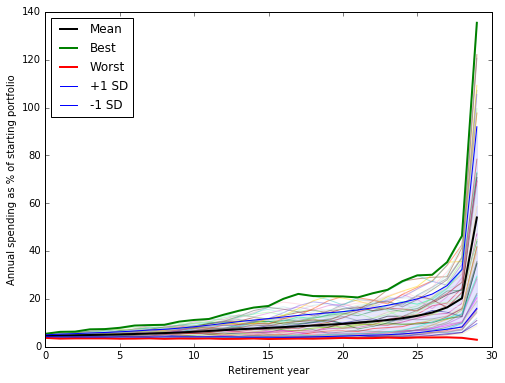

In [8]:
df_summary = model.cohort_history.summarize_by_year()
df_years = model.cohort_history.spend_by_year()

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

from matplotlib import colors
mycolors =  list(colors.cnames)
random.shuffle(mycolors)

for ix in range(model.first_year, model.first_year + model.ret_cohorts):
    plt.plot(df_years[str(ix)], linewidth=1, color=mycolors[ix-model.first_year], alpha=0.5, label='_nolegend_')


plt.plot(df_summary.spend_mean, color='k', linewidth=2, label='Mean')
plt.plot(df_summary.spend_max, color='g', linewidth=2, label='Best')
plt.plot(df_summary.spend_min, color='r', linewidth=2, label='Worst')
plt.plot(df_summary.spend_mean + df_summary.spend_sd, color='b', linewidth=1, label='+1 SD')
plt.plot(df_summary.spend_mean - df_summary.spend_sd, color='b', linewidth=1, label='-1 SD')
plt.fill_between(df_summary.index, df_summary.spend_mean + df_summary.spend_sd, 
                 df_summary.spend_mean - df_summary.spend_sd, color='blue', alpha='0.1')

plt.ylabel("Annual spending as % of starting portfolio")
plt.xlabel("Retirement year")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1])
plt.show()



In [9]:
df_summary['const_spend'] = const_spend
df_summary['var_spend'] = var_spend_pcts * 100
df_summary['stocks'] = stock_allocations * 100
df_summary['bonds'] = 100 - df_summary['stocks']
cols = ['const_spend', 'var_spend', 'stocks', 'bonds', 'spend_mean', 'spend_min', 'spend_max']
df_summary[cols]



,const_spend,var_spend,stocks,bonds,spend_mean,spend_min,spend_max
0,2.25168,2.203127,81.789336,18.210664,4.604840,3.724279,5.431478
1,2.25168,2.287617,81.584539,18.415461,4.731527,3.418391,6.254532
2,2.25168,2.349896,81.042750,18.957250,4.826188,3.513405,6.347958
3,2.25168,2.400992,80.498949,19.501051,4.932219,3.517121,7.302567
4,2.25168,2.457950,79.886688,20.113312,5.049210,3.505759,7.408146
5,2.25168,2.529678,79.489911,20.510089,5.197089,3.386326,7.941039
6,2.25168,2.606445,79.154073,20.845927,5.351562,3.420979,8.891322
7,2.25168,2.713869,78.390047,21.609953,5.557626,3.522455,9.081053
8,2.25168,2.836364,77.651215,22.348785,5.743047,3.348000,9.203257
9,2.25168,2.981631,77.651215,22.348785,5.980422,3.458124,10.540080


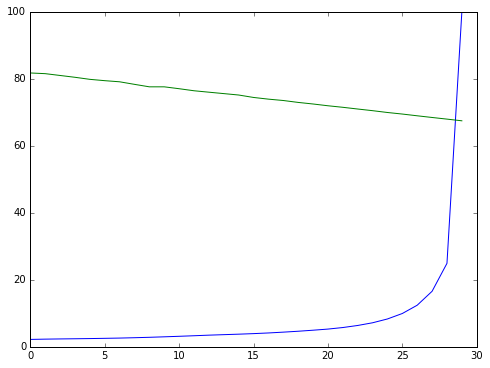

In [10]:
plt.plot(df_summary['var_spend'])
plt.plot(df_summary['stocks'])
plt.show()



In [11]:
from decimal import *
getcontext().prec = 32

def u (cashflow, gamma):
    d_cashflow = Decimal(cashflow)
    d_gamma = Decimal(gamma)
    d_one = Decimal('1.00000000000000000000000000000000')
    
    if gamma != 1:
        one_minus_gamma = d_one - d_gamma
        u = (d_cashflow ** one_minus_gamma - d_one) / one_minus_gamma
        return u
    else:
        return d_cashflow.ln()


x = np.linspace(0,10,1001)
y0 = np.array([u(z, 0.0) for z in x])
y1 = np.array([u(z, 1.0) for z in x])
y2 = np.array([u(z, 2.0) for z in x])
y4 = np.array([u(z, 4.0) for z in x])
y8 = np.array([u(z, 8.0) for z in x])
y16 = np.array([u(z, 16.0) for z in x])
y32 = np.array([u(z, 32.0) for z in x])

# note, at high gamma, can barely distinguish 9.9 from 10
# even with extra decimal places vs. float64
y32

array([Decimal('-Infinity'),
       Decimal('-3.2258064516129011441382804407354E+60'),
       Decimal('-1.5021331848636740558493325676468E+51'), ...,
       Decimal('0.032258064516129032258064516129029'),
       Decimal('0.032258064516129032258064516129029'),
       Decimal('0.032258064516129032258064516129029')], dtype=object)

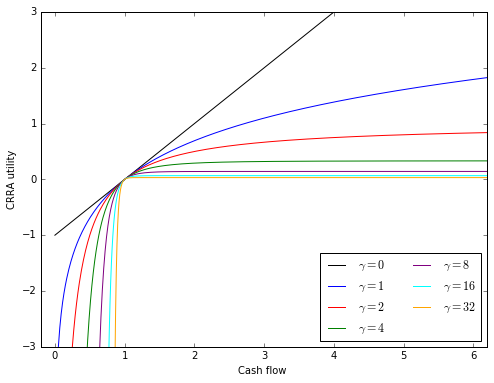

In [12]:
plt.axis([ -0.2, 6.2, -3.0, 3,])

plt.plot(x, y0, color='k', label = r'$\gamma = 0$')
plt.plot(x, y1, color='b', label = r'$\gamma = 1$')
plt.plot(x, y2, color='r', label = r'$\gamma = 2$')
plt.plot(x, y4, color='g', label = r'$\gamma = 4$')
plt.plot(x, y8, color='purple', label = r'$\gamma = 8$')
plt.plot(x, y16, color='cyan', label = r'$\gamma = 16$')
plt.plot(x, y32, color='orange', label = r'$\gamma = 32$')

plt.ylabel("CRRA utility")
plt.xlabel("Cash flow ")
plt.legend(loc="lower right", ncol=2, bbox_to_anchor=[1, 0])



23:03:27 Create TensorFlow graph and session
23:03:27 Create constants stocks_return
23:03:27 Create constants bonds_return
23:03:27 Create variables stocks_alloc
23:03:27 Create ops for soft constraint alloc_min_0 > 0
23:03:27 Create ops for soft constraint alloc_max_1 < 1
23:03:27 Create ops for soft constraint, declining stock alloc alloc_decrease
23:03:27 Create ops for bonds_alloc
23:03:28 Create variables var_spend
23:03:28 Create ops for soft constraint vspend_min_0 > 0
23:03:28 Create cohort history, years 1928 to 1986


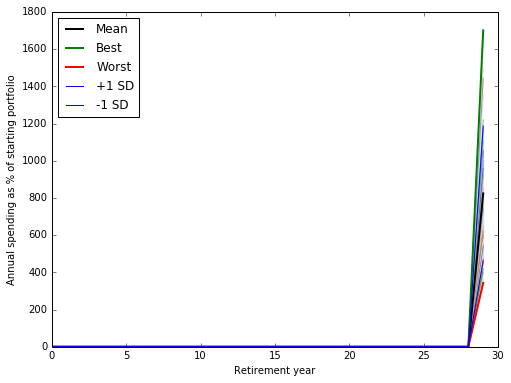

,const_spend,var_spend,stocks,bonds,spend_mean,spend_min,spend_max
0,0.0,0.0,100.0,0.0,0.000000,0.000000,0.000000
1,0.0,0.0,100.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,100.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,100.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,100.0,0.0,0.000000,0.000000,0.000000
5,0.0,0.0,100.0,0.0,0.000000,0.000000,0.000000
6,0.0,0.0,100.0,0.0,0.000000,0.000000,0.000000
7,0.0,0.0,100.0,0.0,0.000000,0.000000,0.000000
8,0.0,0.0,100.0,0.0,0.000000,0.000000,0.000000
9,0.0,0.0,100.0,0.0,0.000000,0.000000,0.000000


In [20]:
# gamma = 0

const_spend = 0.000000
var_spend_pcts = pd.Series([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
stock_allocations = pd.Series([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

model = SafeWithdrawalModel(returns_list = [real_stocks, real_bonds],
                            names_list = ["stocks","bonds"],
                            allocations_list = [stock_allocations, bond_allocations],
                            start_val = 100.0,
                            const_spend = const_spend,
                            var_spend_pcts = var_spend_pcts,
                            gamma = 0.0,
                            survival=None
)

# generate cohorts
model.cohort_history = CohortHistory(model)

df_summary = model.cohort_history.summarize_by_year()
df_years = model.cohort_history.spend_by_year()

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

from matplotlib import colors
mycolors =  list(colors.cnames)
random.shuffle(mycolors)

for ix in range(model.first_year, model.first_year + model.ret_cohorts):
    plt.plot(df_years[str(ix)], linewidth=1, color=mycolors[ix-model.first_year], alpha=0.5, label='_nolegend_')


plt.plot(df_summary.spend_mean, color='k', linewidth=2, label='Mean')
plt.plot(df_summary.spend_max, color='g', linewidth=2, label='Best')
plt.plot(df_summary.spend_min, color='r', linewidth=2, label='Worst')
plt.plot(df_summary.spend_mean + df_summary.spend_sd, color='b', linewidth=1, label='+1 SD')
plt.plot(df_summary.spend_mean - df_summary.spend_sd, color='b', linewidth=1, label='-1 SD')
plt.fill_between(df_summary.index, df_summary.spend_mean + df_summary.spend_sd, 
                 df_summary.spend_mean - df_summary.spend_sd, color='blue', alpha='0.1')

plt.ylabel("Annual spending as % of starting portfolio")
plt.xlabel("Retirement year")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1])
plt.show()

df_summary['const_spend'] = const_spend
df_summary['var_spend'] = var_spend_pcts * 100
df_summary['stocks'] = stock_allocations * 100
df_summary['bonds'] = 100 - df_summary['stocks']
cols = ['const_spend', 'var_spend', 'stocks', 'bonds', 'spend_mean', 'spend_min', 'spend_max']
df_summary[cols]

23:12:53 Create TensorFlow graph and session
23:12:53 Create constants stocks_return
23:12:53 Create constants bonds_return
23:12:53 Create variables stocks_alloc
23:12:53 Create ops for soft constraint alloc_min_0 > 0
23:12:53 Create ops for soft constraint alloc_max_1 < 1
23:12:53 Create ops for soft constraint, declining stock alloc alloc_decrease
23:12:53 Create ops for bonds_alloc
23:12:53 Create variables var_spend
23:12:54 Create ops for soft constraint vspend_min_0 > 0
23:12:54 Create cohort history, years 1928 to 1986


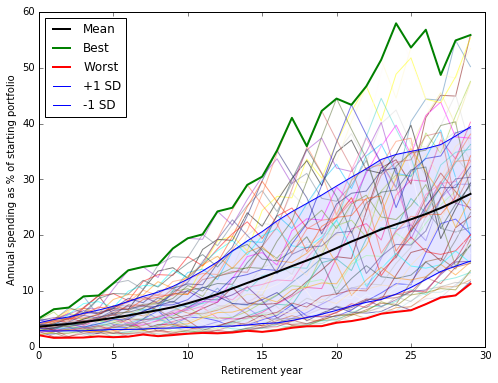

,const_spend,var_spend,stocks,bonds,spend_mean,spend_min,spend_max
0,0.031171,3.303172,99.997992,0.002008,3.600721,2.071306,5.095016
1,0.031171,3.417966,99.997829,0.002171,3.856794,1.602001,6.729255
2,0.031171,3.541324,99.997773,0.002227,4.111977,1.633576,7.031224
3,0.031171,3.674042,99.997740,0.002260,4.435416,1.659801,9.039224
4,0.031171,3.817052,99.998188,0.001812,4.784394,1.859201,9.190331
5,0.031171,3.971432,99.997169,0.002831,5.186025,1.719156,11.383584
6,0.031171,4.138478,99.998297,0.001703,5.616232,1.822693,13.704110
7,0.031171,4.319865,99.997719,0.002281,6.107460,2.196060,14.320802
8,0.031171,4.517450,99.995206,0.004794,6.557605,1.904904,14.711289
9,0.031171,4.733773,99.993388,0.006612,7.097155,2.102124,17.622327


In [25]:
# gamma = 1
#Objective: 9.3197835039548

const_spend = 0.031171

var_spend_pcts = pd.Series([0.033031715082124893, 0.034179658923378056, 0.035413235673810203, 0.03674041861668869, 0.038170522767858685, 0.039714318485430097, 0.041384780016445105, 0.043198654605266659, 0.045174497287581369, 0.047337726241673178, 0.049718885196671697, 0.052349339898335248, 0.05527231487699432, 0.058542485334810268, 0.062223822202370035, 0.066393675531524268, 0.071154938924494274, 0.076645922264574853, 0.083051431231744757, 0.090624657670722322, 0.099713290522915235, 0.11081878154864604, 0.12469530025942732, 0.14253675149889414, 0.16632259898937693, 0.19961900493553258, 0.24956175256190519, 0.33278703965562378, 0.49873317722521254, 1.000000000])
stock_allocations = pd.Series([0.99997992186395857, 0.99997829495822088, 0.99997772801721752, 0.99997739871117364, 0.999981881805168, 0.99997168753575605, 0.99998297109656353, 0.99997718621226794, 0.99995206407097303, 0.99993387591616201, 0.99991562318746663, 0.99989638853120155, 0.99987202763403471, 0.99986392544055869, 0.99985827635323554, 0.99985583354131069, 0.99981745777551367, 0.99980538100009697, 0.99977354919295003, 0.99968776769934442, 0.99963126320848172, 0.99956977316432905, 0.99943095802616133, 0.99939580691208751, 0.99922584340950216, 0.98242971040593718, 0.97558375257576069, 0.95743881935199782, 0.9327435399245898, 0.91540890472708358])

model = SafeWithdrawalModel(returns_list = [real_stocks, real_bonds],
                            names_list = ["stocks","bonds"],
                            allocations_list = [stock_allocations, bond_allocations],
                            start_val = 100.0,
                            const_spend = const_spend,
                            var_spend_pcts = var_spend_pcts,
                            gamma = 1.0,
                            survival=None
)

# generate cohorts
model.cohort_history = CohortHistory(model)

df_summary = model.cohort_history.summarize_by_year()
df_years = model.cohort_history.spend_by_year()

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

from matplotlib import colors
mycolors =  list(colors.cnames)
random.shuffle(mycolors)

for ix in range(model.first_year, model.first_year + model.ret_cohorts):
    plt.plot(df_years[str(ix)], linewidth=1, color=mycolors[ix-model.first_year], alpha=0.5, label='_nolegend_')


plt.plot(df_summary.spend_mean, color='k', linewidth=2, label='Mean')
plt.plot(df_summary.spend_max, color='g', linewidth=2, label='Best')
plt.plot(df_summary.spend_min, color='r', linewidth=2, label='Worst')
plt.plot(df_summary.spend_mean + df_summary.spend_sd, color='b', linewidth=1, label='+1 SD')
plt.plot(df_summary.spend_mean - df_summary.spend_sd, color='b', linewidth=1, label='-1 SD')
plt.fill_between(df_summary.index, df_summary.spend_mean + df_summary.spend_sd, 
                 df_summary.spend_mean - df_summary.spend_sd, color='blue', alpha='0.1')

plt.ylabel("Annual spending as % of starting portfolio")
plt.xlabel("Retirement year")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1])
plt.show()

df_summary['const_spend'] = const_spend
df_summary['var_spend'] = var_spend_pcts * 100
df_summary['stocks'] = stock_allocations * 100
df_summary['bonds'] = 100 - df_summary['stocks']
cols = ['const_spend', 'var_spend', 'stocks', 'bonds', 'spend_mean', 'spend_min', 'spend_max']
df_summary[cols]

23:17:26 Create TensorFlow graph and session
23:17:26 Create constants stocks_return
23:17:26 Create constants bonds_return
23:17:26 Create variables stocks_alloc
23:17:26 Create ops for soft constraint alloc_min_0 > 0
23:17:26 Create ops for soft constraint alloc_max_1 < 1
23:17:26 Create ops for soft constraint, declining stock alloc alloc_decrease
23:17:26 Create ops for bonds_alloc
23:17:27 Create variables var_spend
23:17:27 Create ops for soft constraint vspend_min_0 > 0
23:17:27 Create cohort history, years 1928 to 1986


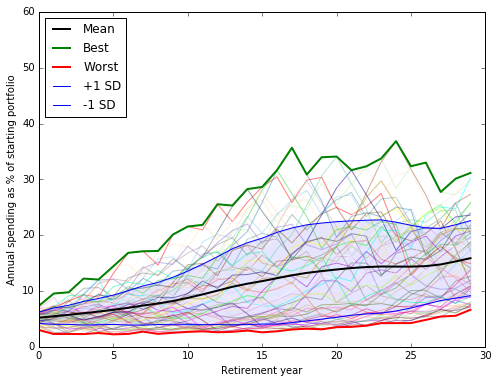

,const_spend,var_spend,stocks,bonds,spend_mean,spend_min,spend_max
0,0.046855,4.772826,99.711356,0.288644,5.203635,2.998506,7.356976
1,0.046855,4.941159,99.185702,0.814298,5.488918,2.292409,9.553024
2,0.046855,5.092873,99.185702,0.814298,5.727510,2.298502,9.765847
3,0.046855,5.234406,98.948774,1.051226,6.018109,2.280631,12.224434
4,0.046855,5.373246,98.804541,1.195459,6.305863,2.468762,12.053960
5,0.046855,5.521750,98.050079,1.949921,6.633666,2.234612,14.437698
6,0.046855,5.694143,97.838578,2.161422,6.985119,2.312571,16.839349
7,0.046855,5.893058,97.570009,2.429991,7.397269,2.717164,17.125006
8,0.046855,6.133698,96.829251,3.170749,7.759953,2.314782,17.166610
9,0.046855,6.404165,96.617128,3.382872,8.207808,2.510630,20.109341


In [29]:
# gamma = 2

#Objective: 7.203952

const_spend = 0.046854624598
var_spend_pcts = pd.Series([0.047728264432767613, 0.049411586294458174, 0.050928730122509078, 0.052344059676851309, 0.053732462146116412, 0.055217497823138666, 0.056941428407520825, 0.058930575848900338, 0.061336975451643787, 0.064041651590614299, 0.06682753017916232, 0.070015470233890598, 0.073482705866412062, 0.076908841885018162, 0.080315624573920857, 0.084248536285915637, 0.089148601519763754, 0.095047696579182661, 0.10188621415545694, 0.10924998386213798, 0.11753781748010764, 0.12760941026239583, 0.14057616911360005, 0.15671714345938417, 0.17824144932079172, 0.20888271848116302, 0.25566892685213716, 0.33619449575112598, 0.50043350250247753, 1.000000000])
stock_allocations = pd.Series([0.99711355898839182, 0.99185701715221553, 0.99185701715220687, 0.98948774204807233, 0.98804540916535932, 0.98050079038519222, 0.97838578028389156, 0.97570008842349965, 0.96829250940421685, 0.96617128141912056, 0.96431002414689537, 0.96114519866116632, 0.96040289451991445, 0.95545525944604093, 0.94576492604012397, 0.94367216489810268, 0.93893019681658063, 0.93669535102064716, 0.9364792192199255, 0.92797207023216266, 0.92732340472916697, 0.92640611763229774, 0.92378045399910658, 0.92361726501803854, 0.92237182045552468, 0.91465926097427197, 0.90751802261070524, 0.89860934516344027, 0.89319891609596413, 0.8756356436940772])

model = SafeWithdrawalModel(returns_list = [real_stocks, real_bonds],
                            names_list = ["stocks","bonds"],
                            allocations_list = [stock_allocations, bond_allocations],
                            start_val = 100.0,
                            const_spend = const_spend,
                            var_spend_pcts = var_spend_pcts,
                            gamma = 2.0,
                            survival=None
)

# generate cohorts
model.cohort_history = CohortHistory(model)

df_summary = model.cohort_history.summarize_by_year()
df_years = model.cohort_history.spend_by_year()

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

from matplotlib import colors
mycolors =  list(colors.cnames)
random.shuffle(mycolors)

for ix in range(model.first_year, model.first_year + model.ret_cohorts):
    plt.plot(df_years[str(ix)], linewidth=1, color=mycolors[ix-model.first_year], alpha=0.5, label='_nolegend_')


plt.plot(df_summary.spend_mean, color='k', linewidth=2, label='Mean')
plt.plot(df_summary.spend_max, color='g', linewidth=2, label='Best')
plt.plot(df_summary.spend_min, color='r', linewidth=2, label='Worst')
plt.plot(df_summary.spend_mean + df_summary.spend_sd, color='b', linewidth=1, label='+1 SD')
plt.plot(df_summary.spend_mean - df_summary.spend_sd, color='b', linewidth=1, label='-1 SD')
plt.fill_between(df_summary.index, df_summary.spend_mean + df_summary.spend_sd, 
                 df_summary.spend_mean - df_summary.spend_sd, color='blue', alpha='0.1')

plt.ylabel("Annual spending as % of starting portfolio")
plt.xlabel("Retirement year")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1])
plt.axis([ 0, 30, 0, 60,])

plt.show()

df_summary['const_spend'] = const_spend
df_summary['var_spend'] = var_spend_pcts * 100
df_summary['stocks'] = stock_allocations * 100
df_summary['bonds'] = 100 - df_summary['stocks']
cols = ['const_spend', 'var_spend', 'stocks', 'bonds', 'spend_mean', 'spend_min', 'spend_max']
df_summary[cols]

23:21:58 Create TensorFlow graph and session
23:21:58 Create constants stocks_return
23:21:58 Create constants bonds_return
23:21:58 Create variables stocks_alloc
23:21:58 Create ops for soft constraint alloc_min_0 > 0
23:21:58 Create ops for soft constraint alloc_max_1 < 1
23:21:58 Create ops for soft constraint, declining stock alloc alloc_decrease
23:21:58 Create ops for bonds_alloc
23:21:59 Create variables var_spend
23:21:59 Create ops for soft constraint vspend_min_0 > 0
23:21:59 Create cohort history, years 1928 to 1986


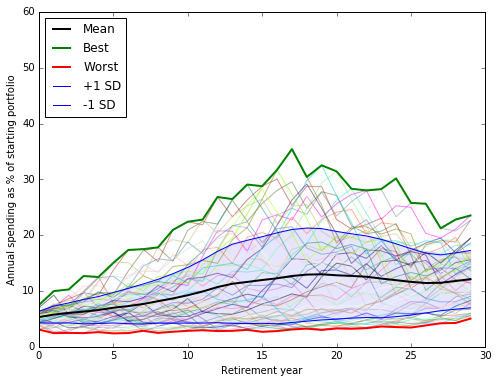

,const_spend,var_spend,stocks,bonds,spend_mean,spend_min,spend_max
0,0.062395,4.873002,98.483042,1.516958,5.323286,3.092691,7.496455
1,0.062395,5.200831,97.770713,2.229287,5.774631,2.444812,9.980807
2,0.062395,5.421819,97.525613,2.474387,6.071221,2.490796,10.274116
3,0.062395,5.531251,96.912900,3.087100,6.301435,2.452856,12.683934
4,0.062395,5.692454,96.881302,3.118698,6.590478,2.629395,12.508130
5,0.062395,5.934685,96.237800,3.762200,7.000297,2.405804,15.037976
6,0.062395,6.094611,96.234195,3.765805,7.299947,2.464288,17.351973
7,0.062395,6.291529,95.851705,4.148295,7.667989,2.868621,17.497963
8,0.062395,6.691049,95.422896,4.577104,8.174107,2.487247,17.821177
9,0.062395,7.052389,95.417380,4.582620,8.665520,2.695719,20.947960


In [32]:
# gamma = 4
#Objective: 5.542043

const_spend = 0.062394818590
var_spend_pcts = pd.Series([0.048730017411681981, 0.052008310068007907, 0.054218193590686803, 0.055312510831961072, 0.05692453529569181, 0.059346850704198942, 0.060946112437266921, 0.062915293825371824, 0.066910490847796711, 0.070523890712361842, 0.074071743670764315, 0.078407393759707497, 0.083816486978216462, 0.087649497384592573, 0.090666848258244878, 0.09516947034014607, 0.10018529958488882, 0.10723772404790377, 0.11502346628583779, 0.12290203018621258, 0.12976582756950256, 0.13907927847917723, 0.15173726025749013, 0.16591027751436746, 0.18646105551063419, 0.21552328379408389, 0.25984829312381236, 0.33830099662564217, 0.50158087213236147, 1.0000000001165821])
stock_allocations = pd.Series([0.98483041858618714, 0.97770712573282248, 0.97525612643584925, 0.9691289957653666, 0.96881302159684457, 0.96237799840558991, 0.96234194683263252, 0.95851705138673715, 0.95422896281588088, 0.95417380209558689, 0.9541536262809267, 0.95136146540864797, 0.95015346534484879, 0.94863300656047456, 0.93975410613038846, 0.93725390691100396, 0.93177292466854633, 0.92676214815504188, 0.91778513469130074, 0.91050570402803632, 0.90965214873288602, 0.90836304468480333, 0.90502808487792075, 0.8953285399227876, 0.89332014954909367, 0.8851021144470862, 0.87791118448773353, 0.86886484784575391, 0.86325931670778011, 0.85567452029220781])

model = SafeWithdrawalModel(returns_list = [real_stocks, real_bonds],
                            names_list = ["stocks","bonds"],
                            allocations_list = [stock_allocations, bond_allocations],
                            start_val = 100.0,
                            const_spend = const_spend,
                            var_spend_pcts = var_spend_pcts,
                            gamma = 4.0,
                            survival=None
)

# generate cohorts
model.cohort_history = CohortHistory(model)

df_summary = model.cohort_history.summarize_by_year()
df_years = model.cohort_history.spend_by_year()

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

from matplotlib import colors
mycolors =  list(colors.cnames)
random.shuffle(mycolors)

for ix in range(model.first_year, model.first_year + model.ret_cohorts):
    plt.plot(df_years[str(ix)], linewidth=1, color=mycolors[ix-model.first_year], alpha=0.5, label='_nolegend_')


plt.plot(df_summary.spend_mean, color='k', linewidth=2, label='Mean')
plt.plot(df_summary.spend_max, color='g', linewidth=2, label='Best')
plt.plot(df_summary.spend_min, color='r', linewidth=2, label='Worst')
plt.plot(df_summary.spend_mean + df_summary.spend_sd, color='b', linewidth=1, label='+1 SD')
plt.plot(df_summary.spend_mean - df_summary.spend_sd, color='b', linewidth=1, label='-1 SD')
plt.fill_between(df_summary.index, df_summary.spend_mean + df_summary.spend_sd, 
                 df_summary.spend_mean - df_summary.spend_sd, color='blue', alpha='0.1')

plt.ylabel("Annual spending as % of starting portfolio")
plt.xlabel("Retirement year")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1])
plt.axis([ 0, 30, 0, 60,])

plt.show()

df_summary['const_spend'] = const_spend
df_summary['var_spend'] = var_spend_pcts * 100
df_summary['stocks'] = stock_allocations * 100
df_summary['bonds'] = 100 - df_summary['stocks']
cols = ['const_spend', 'var_spend', 'stocks', 'bonds', 'spend_mean', 'spend_min', 'spend_max']
df_summary[cols]

00:46:45 Create TensorFlow graph and session
00:46:45 Create constants stocks_return
00:46:45 Create constants bonds_return
00:46:46 Create variables stocks_alloc
00:46:46 Create ops for soft constraint alloc_min_0 > 0
00:46:46 Create ops for soft constraint alloc_max_1 < 1
00:46:46 Create ops for soft constraint, declining stock alloc alloc_decrease
00:46:46 Create ops for bonds_alloc
00:46:46 Create variables var_spend
00:46:47 Create ops for soft constraint vspend_min_0 > 0
00:46:47 Create cohort history, years 1928 to 1986


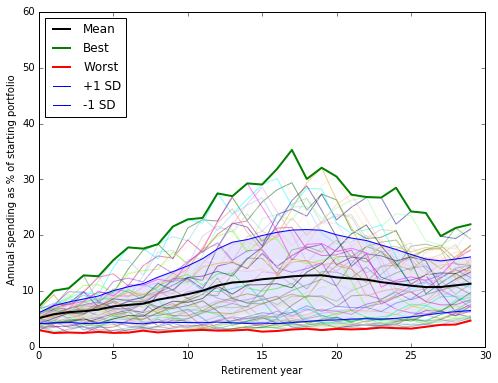

,const_spend,var_spend,stocks,bonds,spend_mean,spend_min,spend_max
0,0.06638,4.694249,98.233688,1.766312,5.133483,2.988783,7.221975
1,0.06638,5.238187,97.574163,2.425837,5.828716,2.473801,10.061401
2,0.06638,5.537630,97.385639,2.614361,6.210254,2.554859,10.496129
3,0.06638,5.585798,96.912930,3.087070,6.365898,2.485217,12.801414
4,0.06638,5.758377,96.730711,3.269289,6.664292,2.665238,12.645715
5,0.06638,6.150652,96.120678,3.879322,7.244616,2.494808,15.538026
6,0.06638,6.288385,96.112519,3.887481,7.503502,2.537379,17.814123
7,0.06638,6.371454,95.822593,4.177407,7.720755,2.890921,17.595814
8,0.06638,6.959311,95.325751,4.674249,8.442864,2.572540,18.391221
9,0.06638,7.334052,95.325751,4.674249,8.922394,2.780088,21.545583


In [50]:
# gamma = 6

#Objective: 4.785632

const_spend = 0.066380048274
var_spend_pcts = pd.Series([0.046942489991125415, 0.052381867750906946, 0.055376304144526919, 0.055857984716955966, 0.057583771265202859, 0.06150651982169935, 0.062883848853336297, 0.06371453884366847, 0.069593106013293091, 0.073340523370016814, 0.076543277055569098, 0.080832500026518719, 0.087518278291160476, 0.091425365331841354, 0.093769994376575891, 0.099211209335377887, 0.10421549460702235, 0.11100390900033544, 0.11865455928527642, 0.12712502511942428, 0.13280328161552832, 0.14161239780070853, 0.15435903942239249, 0.1672445482599117, 0.18779214759395108, 0.21664861706166127, 0.2601965170565872, 0.33828814537170426, 0.50158637558403174, 1.0])
stock_allocations = pd.Series([0.9823368781066294, 0.97574163093473221, 0.97385639120022749, 0.96912930315347301, 0.96730711445602935, 0.96120678292173423, 0.96112518736605979, 0.95822593280757651, 0.95325751135175252, 0.9532575110571978, 0.9532344090976832, 0.95104972867096116, 0.9494207410006561, 0.94863917813797216, 0.93966140738841597, 0.93705157759905322, 0.93182034051946938, 0.92637966735950883, 0.91781119466330885, 0.91043108963693997, 0.90952857245067864, 0.90818966577947924, 0.904801572109318, 0.89527003579457665, 0.89320998933594076, 0.88491434302897254, 0.87778410584111077, 0.86881129473149388, 0.86323868426060357, 0.85566504051746828])
model = SafeWithdrawalModel(returns_list = [real_stocks, real_bonds],
                            names_list = ["stocks","bonds"],
                            allocations_list = [stock_allocations, bond_allocations],
                            start_val = 100.0,
                            const_spend = const_spend,
                            var_spend_pcts = var_spend_pcts,
                            gamma = 6.0,
                            survival=None
)

# generate cohorts
model.cohort_history = CohortHistory(model)

df_summary = model.cohort_history.summarize_by_year()
df_years = model.cohort_history.spend_by_year()

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

from matplotlib import colors
mycolors =  list(colors.cnames)
random.shuffle(mycolors)

for ix in range(model.first_year, model.first_year + model.ret_cohorts):
    plt.plot(df_years[str(ix)], linewidth=1, color=mycolors[ix-model.first_year], alpha=0.5, label='_nolegend_')


plt.plot(df_summary.spend_mean, color='k', linewidth=2, label='Mean')
plt.plot(df_summary.spend_max, color='g', linewidth=2, label='Best')
plt.plot(df_summary.spend_min, color='r', linewidth=2, label='Worst')
plt.plot(df_summary.spend_mean + df_summary.spend_sd, color='b', linewidth=1, label='+1 SD')
plt.plot(df_summary.spend_mean - df_summary.spend_sd, color='b', linewidth=1, label='-1 SD')
plt.fill_between(df_summary.index, df_summary.spend_mean + df_summary.spend_sd, 
                 df_summary.spend_mean - df_summary.spend_sd, color='blue', alpha='0.1')

plt.ylabel("Annual spending as % of starting portfolio")
plt.xlabel("Retirement year")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1])
plt.axis([ 0, 30, 0, 60,])

plt.show()

df_summary['const_spend'] = const_spend
df_summary['var_spend'] = var_spend_pcts * 100
df_summary['stocks'] = stock_allocations * 100
df_summary['bonds'] = 100 - df_summary['stocks']
cols = ['const_spend', 'var_spend', 'stocks', 'bonds', 'spend_mean', 'spend_min', 'spend_max']
df_summary[cols]

23:36:47 Create TensorFlow graph and session
23:36:47 Create constants stocks_return
23:36:47 Create constants bonds_return
23:36:47 Create variables stocks_alloc
23:36:47 Create ops for soft constraint alloc_min_0 > 0
23:36:47 Create ops for soft constraint alloc_max_1 < 1
23:36:48 Create ops for soft constraint, declining stock alloc alloc_decrease
23:36:48 Create ops for bonds_alloc
23:36:48 Create variables var_spend
23:36:48 Create ops for soft constraint vspend_min_0 > 0
23:36:48 Create cohort history, years 1928 to 1986


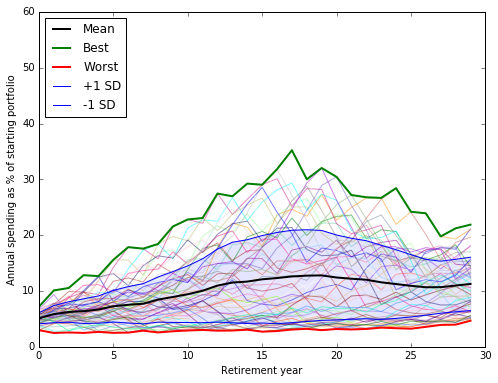

,const_spend,var_spend,stocks,bonds,spend_mean,spend_min,spend_max
0,0.066539,4.673861,98.222866,1.777134,5.111600,2.976391,7.190807
1,0.066539,5.257821,97.563324,2.436676,5.851629,2.483673,10.100528
2,0.066539,5.560403,97.379556,2.620444,6.235609,2.565487,10.538510
3,0.066539,5.602287,96.912953,3.087047,6.383050,2.492150,12.835580
4,0.066539,5.769069,96.728011,3.271989,6.673849,2.669261,12.663803
5,0.066539,6.177014,96.116505,3.883495,7.271577,2.504174,15.595097
6,0.066539,6.310656,96.114240,3.885760,7.523794,2.544270,17.861657
7,0.066539,6.375279,95.823537,4.176463,7.717307,2.889671,17.587088
8,0.066539,6.979234,95.418392,4.581608,8.458109,2.576053,18.424915
9,0.066539,7.348296,95.324302,4.675698,8.928373,2.781371,21.554082


In [43]:
#gamma = 8

#Objective: 4.344292

const_spend = 0.066538868236
var_spend_pcts = pd.Series([0.046738613400720157, 0.052578212331701422, 0.055604031991144054, 0.056022867641020879, 0.057690694919215656, 0.061770142012811377, 0.063106556759141882, 0.063752793177456912, 0.069792342789740017, 0.073482958654542213, 0.076628286680646529, 0.080881261799524609, 0.087615661447915424, 0.091523532688704792, 0.093830476679064898, 0.099316484584904705, 0.10431742236079763, 0.1110747451023619, 0.11871473457622117, 0.12721163543407124, 0.13286513528335064, 0.14167109586199056, 0.15442861904905222, 0.16728842599129523, 0.18784170097529398, 0.21669686703068189, 0.26022055000599115, 0.33829748628390444, 0.50159181598691882, 1.0])
stock_allocations = pd.Series([0.98222866429135214, 0.97563324068554025, 0.97379555563150988, 0.9691295331731038, 0.96728011171618633, 0.96116505282781062, 0.96114239602900542, 0.9582353657349566, 0.95418391865355312, 0.95324301670733713, 0.95224537364245299, 0.95104770592332288, 0.94940822135558678, 0.94865630709534388, 0.93967988457235629, 0.93706436102547297, 0.93183422330506882, 0.92637390183047841, 0.91781855076830809, 0.91044203986889627, 0.90953803147697587, 0.90819640840180615, 0.90480389222271274, 0.89527804644637532, 0.89321353646032575, 0.88491359202162156, 0.87778431762444609, 0.8688118901276034, 0.86323871800759366, 0.85566511406570356])


model = SafeWithdrawalModel(returns_list = [real_stocks, real_bonds],
                            names_list = ["stocks","bonds"],
                            allocations_list = [stock_allocations, bond_allocations],
                            start_val = 100.0,
                            const_spend = const_spend,
                            var_spend_pcts = var_spend_pcts,
                            gamma = 8.0,
                            survival=None
)

# generate cohorts
model.cohort_history = CohortHistory(model)

df_summary = model.cohort_history.summarize_by_year()
df_years = model.cohort_history.spend_by_year()

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

from matplotlib import colors
mycolors =  list(colors.cnames)
random.shuffle(mycolors)

for ix in range(model.first_year, model.first_year + model.ret_cohorts):
    plt.plot(df_years[str(ix)], linewidth=1, color=mycolors[ix-model.first_year], alpha=0.5, label='_nolegend_')


plt.plot(df_summary.spend_mean, color='k', linewidth=2, label='Mean')
plt.plot(df_summary.spend_max, color='g', linewidth=2, label='Best')
plt.plot(df_summary.spend_min, color='r', linewidth=2, label='Worst')
plt.plot(df_summary.spend_mean + df_summary.spend_sd, color='b', linewidth=1, label='+1 SD')
plt.plot(df_summary.spend_mean - df_summary.spend_sd, color='b', linewidth=1, label='-1 SD')
plt.fill_between(df_summary.index, df_summary.spend_mean + df_summary.spend_sd, 
                 df_summary.spend_mean - df_summary.spend_sd, color='blue', alpha='0.1')

plt.ylabel("Annual spending as % of starting portfolio")
plt.xlabel("Retirement year")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1])
plt.axis([ 0, 30, 0, 60,])

plt.show()

df_summary['const_spend'] = const_spend
df_summary['var_spend'] = var_spend_pcts * 100
df_summary['stocks'] = stock_allocations * 100
df_summary['bonds'] = 100 - df_summary['stocks']
cols = ['const_spend', 'var_spend', 'stocks', 'bonds', 'spend_mean', 'spend_min', 'spend_max']
df_summary[cols]

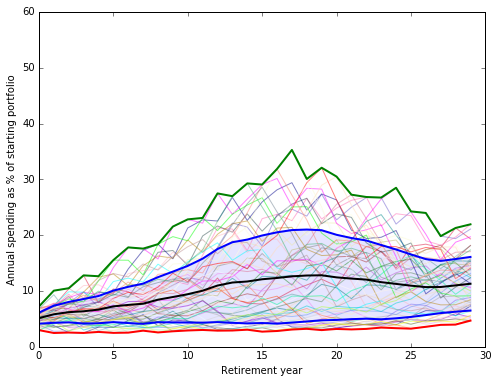

In [51]:
# make a plotly chart
# must add title

import matplotlib.mlab as mlab
import plotly.plotly as py

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

from matplotlib import colors
mycolors =  list(colors.cnames)
random.shuffle(mycolors)

for ix in range(model.first_year, model.first_year + model.ret_cohorts):
    ax.plot(df_years[str(ix)], linewidth=1, color=mycolors[ix-model.first_year], alpha=0.5, label=str(ix))


ax.plot(df_summary.spend_mean, color='k', linewidth=2, label='Mean')
ax.plot(df_summary.spend_max, color='g', linewidth=2, label='Best')
ax.plot(df_summary.spend_min, color='r', linewidth=2, label='Worst')
ax.plot(df_summary.spend_mean + df_summary.spend_sd, color='b', linewidth=2, label='+1 SD')
ax.plot(df_summary.spend_mean - df_summary.spend_sd, color='b', linewidth=2, label='-1 SD')
ax.fill_between(df_summary.index, df_summary.spend_mean + df_summary.spend_sd, 
                 df_summary.spend_mean - df_summary.spend_sd, color='blue', alpha='0.1')

plt.ylabel("Annual spending as % of starting portfolio")
plt.xlabel("Retirement year")
#plotly pukes on legend
#ax.legend(loc="upper left", bbox_to_anchor=[0, 1])
ax.axis([ 0, 30, 0, 60,])

plt.show()


In [52]:
plot_url = py.iplot_mpl(fig, filename='chart')
plot_url